In [175]:
# setup
import pathlib as pl
import math

from matplotlib import pyplot as plt
plt.style.use('seaborn')

%matplotlib inline
# helper functions

def prettyPrintAllocations(procTestLists):
    """
        Pretty-prints a list of lists of test assignments for each processor
    """
    pWidth = 1+len(str(len(procTestLists)))
    tWidth = 1+len(str(max(e for l in procTestLists for e in l)))
    for pIdx, tList in enumerate(procTestLists):        
        print("proc {:>{pWidth}} > {}".format(pIdx, " ".join("{:>{tWidth}}".format(t, tWidth=tWidth) for t in tList),
              pWidth=pWidth))

def prettyPrintStats(procTestLists):
    """
        Pretty-prints a list of the number and sums of test assignments for each processor
    """
    counts = [len(l) for l in procTestLists]
    sums = [sum(l) for l in procTestLists]

    pWidth = 1+len(str(len(procTestLists)))
    cntWidth = 1+len(str(max(counts)))
    sumWidth = 1+len(str(max(int(s) for s in sums)))
    for pIdx, (pCnt, pSum) in enumerate(zip(counts, sums)):    
        print("proc {:>{pWidth}} > #{:>{cntWidth}} tests Σ{:>{sumWidth}.2f} seconds".format(pIdx, pCnt, pSum/1000,
                cntWidth=cntWidth, sumWidth=sumWidth, pWidth=pWidth))

def plotTestRuntimeDistribution(testRuntimes):
    tCount = len(testRuntimes)

    unit = 10**int(math.log10(tCount))
    maxTick = unit * (tCount // unit)
    
    plt.plot(range(tCount), sorted(testRuntimes, reverse=True))
    plt.xticks(range(0, 1+maxTick, int(maxTick/5)))
    plt.ylabel("runtime / msecs")
    plt.xlabel("tests sorted by runtime")
    plt.show()
    
def plotDistributions(pSortedSums):
    seriesCount = len(pSortedSums[0])
    pSums = [sum(l)/1000 for l in pSortedSums]
    processorTimes = [s/seriesCount for s in pSums]

    plt.bar(range(procCount),processorTimes)
    plt.ylabel("allocation time total / seconds")
    plt.xlabel("processors sorted by total allocation")
    plt.xticks([])
    plt.show()

# The "Long Pole" Effect in Gradle's Test Execution

When we assign a number of tests (with different runtimes) to multiple processors for parallel execution, the overall test runtime is that of the processor with the highest load as measured by the summed test execution times. Ideally, this approaches the quotient between total test runtime and number of processors. However, when one processor is assigned an unproportionally high load of tests, the overall runtime will depend on this processor: It will have to continue to work off tasks after all other processors have finshed, thus becoming the "long pole" in the runtime.

This phenomenon has been [discussed for Gradle's parallel test execution](https://github.com/gradle/gradle/issues/2669). An important point here is that Gradle will not split up a test class for parallelization, so the smallest unit which we distribute is the test class; if we have classes containing long(er)-running integration-like tests, this increases the potential for running into the "long pole" problem.

## Scheduling

Gradle currently uses a round-robin approach to evenly pre-allocate test classes to multiple processors. This distribution is based solely on the incoming order of the classes; it does not take into account size or other information:

In [176]:
def roundRobin(tests, procCount):
    """ 
    Takes a list of test items and distributes them in a straight-forward round-robin
    fashion amongst the number of given processors.
    :return: a list of `procCount` lists L1 ...Lx, where each Li denotes the tests assigned
             to processor #x.
    """
    procs = [[] for _i in range(procCount)]

    for tIdx, test in enumerate(tests):
        pos = tIdx % procCount
        procs[pos].append(test)
    return procs

If we have 20 tests and 5 processors, they would be distributed as follows:

In [177]:
prettyPrintAllocations(roundRobin(range(20), 5))

proc  0 >   0   5  10  15
proc  1 >   1   6  11  16
proc  2 >   2   7  12  17
proc  3 >   3   8  13  18
proc  4 >   4   9  14  19


 So, if tests **0**, **5**, and **10** happen to take very long, processor **0** would become the long pole in this scenario.

## Experiments

### Getting Runtime Examples

As an example test runtime distribution, we take a look at Gradle's test class runtimes. In Gradle's own `build.gradle.kts`, we can modify the `allprojects` configuration to make the test classes log their runtime:

```kotlin
tasks.withType<Test> {
        outputs.upToDateWhen { false }
        addTestListener(object : TestListener {
            override fun beforeSuite(suite: TestDescriptor) {}
            override fun beforeTest(testDescriptor: TestDescriptor) {}
            override fun afterTest(testDescriptor: TestDescriptor, result: TestResult) {
            }
            override fun afterSuite(suite: TestDescriptor, result: TestResult) {
                val duration = result.endTime - result.startTime
                println(">>> $suite\t${duration}")
            }
        })
    }
```

The resulting times for a few test series are collected in the folder `gradle_test_stats` (see the scripts `timeGradleTests.sh` and `timesOnly.sh` for their generation). Sorting them by runtime and averaging over the series gives an impression of the test classes' runtime distribution:

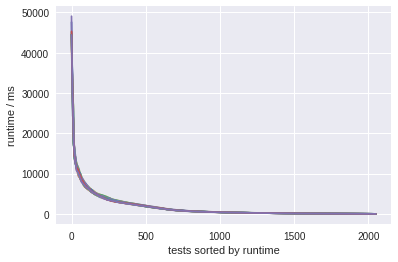

In [178]:
timesFiles = pl.Path("gradle_test_stats").glob("*.times")
sums, seriesCount = None, 0
for tfName in timesFiles:
    with open(tfName) as tff:
        vals = sorted((int(l.strip()) for l in tff), reverse=True)
        sums = vals if sums is None else [v+s for v,s in zip(vals, sums)]
        seriesCount += 1
    plt.plot(vals)
plt.xlabel("tests sorted by runtime")
plt.ylabel("runtime / ms")
plt.show()

In [179]:
import statistics as stats
runtimes = [s/seriesCount for s in sums]
longest, median, shortest = runtimes[0], stats.median(runtimes), runtimes[-1]
print(f"Evaluated {seriesCount} overall test executions with {len(sums)} test classes each.\n"
      f"The total runtime for all test classes was {sum(runtimes)/1000:.2f} seconds on average.\n"
      f"On average, the longest class runtime was {longest/1000:.2f} seconds,\n"
      f"the shortest {shortest:.2f} milliseconds, "
      f"with a median of {median:.2f} milliseconds.")

Evaluated 16 overall test executions with 2053 test classes each.
The total runtime for all test classes was 3348.34 seconds on average.
On average, the longest class runtime was 45.06 seconds,
the shortest 1.44 milliseconds, with a median of 388.00 milliseconds.


The above graph should actually be made up of bars, since each x position is one test, but unfortunately that looked crappy.

If run entirely sequentially, we could expect the test classes to take approx. 55 minutes.

### Simulating Load Distribution

Given these runtimes, we can simulate what the resulting processing times would be with round robin. Since the ordering in Gradle is currently agnostic with regard to size, we shuffle them first. With three processors, the result might look like this:

In [180]:
import random
shuffledTimes = list(runtimes)
random.shuffle(shuffledTimes)

procCount = 3

prettyPrintStats(roundRobin(shuffledTimes, procCount))

proc  0 > # 685 tests Σ 1044.11 seconds
proc  1 > # 684 tests Σ 1259.88 seconds
proc  2 > # 684 tests Σ 1044.34 seconds


The distribution among the processors will vary, but it will most likely not be even. We can sort the processors by assigned sums, and repeat the whole procedure a few times to get an impression of the skew:

In [181]:
def repeatedlyDistribute(testTimes, procCount, seriesCount = 200):
    """
        Shuffle the given test times and repeatedly allocate them to
        the given number of processors.
        
        :return: a list of 'procCount' elements,
                 where each list contains the 'seriesCount' test allocations to that processor
    """

    shuffledTimes = testTimes
    # for each processor, keep a list of the sum over the tests,
    # sorted by summed allocation
    pSortedSums = [[] for _ in range(procCount)]
    for _s in range(seriesCount):
        random.shuffle(shuffledTimes)
        # longest first:
        sortedSums = sorted([sum(l) for l in roundRobin(shuffledTimes, procCount)], reverse=True)
        for pList, s in zip(pSortedSums, sortedSums):
            pList.append(s)

    return pSortedSums

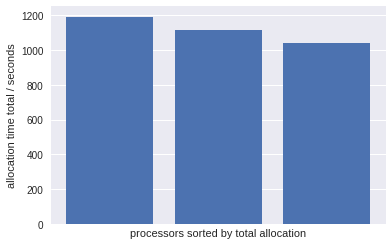

In [182]:
pSortedSums = repeatedlyDistribute(shuffledTimes, procCount)
plotDistributions(pSortedSums)

In [183]:
for pIdx, pTimes in enumerate(processorTimes):
    print(f"Proc {pIdx} > {pTimes:.2f} seconds average allocation")
diff = processorTimes[0]-processorTimes[-1]
print(f"On average, the longest-running proc took {diff:.2f} seconds ({diff/processorTimes[-1]:.1%}) longer than the shortest-running one.")

Proc 0 > 1201.41 seconds average allocation
Proc 1 > 1112.18 seconds average allocation
Proc 2 > 1034.74 seconds average allocation
On average, the longest-running proc took 166.67 seconds (16.1%) longer than the shortest-running one.


There is a slight skew, although it (probably - since this depends on random values) does not seem that big. However, there are some big _buts_ here:

### Bad Ratios

This was only the average ratio. The histogram over the ratios of highest load / smallest load looks like this:

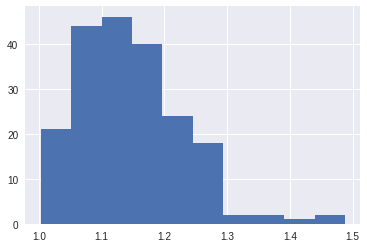

In 3.00% of the cases, the highest load is at least 1.3 times the lowest load.
The maximum ratio of highest to lowest load is 1.49.


In [184]:
def plotAllocationRatioDistribution(pSortedSums, tooMuchThreshold=1.3):
    highestLoadProc, lowestLoadProc = pSortedSums[0], pSortedSums[-1]

    ratios = [h/l for h,l in zip(highestLoadProc, lowestLoadProc)]
    plt.hist(ratios)
    plt.show()

    ratioOfTooMuchRatios = len([r for r in ratios if r >= tooMuchThreshold])/len(ratios)
    print(f"In {ratioOfTooMuchRatios:.2%} of the cases, the highest load is at least {tooMuchThreshold} times the lowest load.")
    print(f"The maximum ratio of highest to lowest load is {max(ratios):.2f}.")

plotAllocationRatioDistribution(pSortedSums)

In practice, AFAIK, for a given set of test classes, the order in which they are processed in Gradle is stable. So any particularly bad example of the test series above might be one constantly encountered for a given set of test classes. This might be the people interested in [issue 2669](https://github.com/gradle/gradle/issues/2669)). Apart from that, a single new test class can make the ordering and allocation of the classes change suddenly.

## Longer tests

The Gradle test suite represents a rather ideal case: It contains very many test classes with mostly very short runtimes (<1 sec). This will look different when you add test classes with runtimes in the minutes. We can generate a collection of random times and add them to the mix:

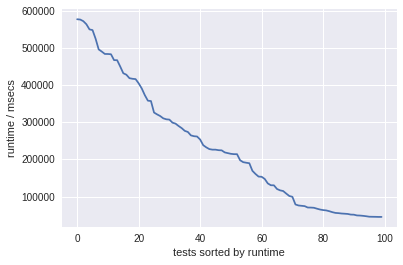

In [185]:
import numpy as np

count = 100
maxDurationMs = 10 * 60 * 1000 # 10 mins in ms
minDurationMs = 45 * 1000 # 45 secs

longerRuntimes = [(maxDurationMs-minDurationMs)*v+minDurationMs for v in np.random.power(0.5, size=(count,))]
plotTestRuntimeDistribution(longerRuntimes)

Adding those to our Gradle tests gives the following times distribution:

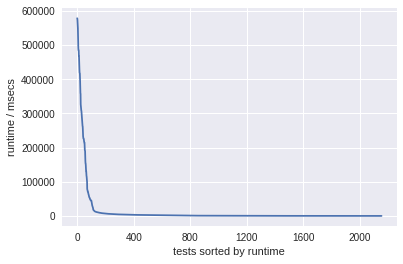

In [186]:
allRuntimes = longerRuntimes + runtimes

plotTestRuntimeDistribution(allRuntimes)

And distributing the tests gives a higher load skew:

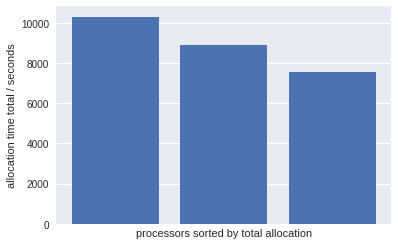

In [187]:
allSortedSums = repeatedlyDistribute(allRuntimes, procCount)
plotDistributions(allSortedSums)

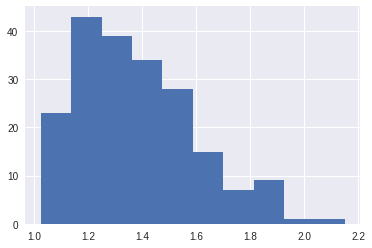

In 28.50% of the cases, the highest load is at least 1.5 times the lowest load.
The maximum ratio of highest to lowest load is 2.15.


In [188]:
plotAllocationRatioDistribution(allSortedSums, tooMuchThreshold=1.5)

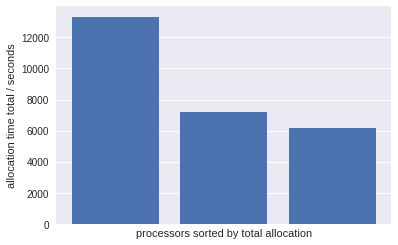

In [189]:
_maxRatio, maxIndex = max((high/low, i) for i, (high, low) in enumerate(zip(allSortedSums[0], allSortedSums[-1])))
plotDistributions([[procList[maxIndex]] for procList in allSortedSums])

## Shifting Round Robin

In [190]:
def shiftingRoundRobin(tests, procCount):
    """ 
    Takes a list of test items and distributes them in a shifting round-robin
    fashion amongst the number of given processors.
    :return: a list of `procCount` lists L1 ...Lx, where each Li denotes the tests assigned
             to processor #x.
    """
    
    procs = [[] for _i in range(procCount)]

    for tIdx, test in enumerate(tests):
        shift = (tIdx//procCount)%procCount
        pos = (shift + tIdx) % procCount
        procs[pos].append(test)
    return procs

In [191]:
res = shiftingRoundRobin(range(15), 3)
prettyPr(res)

NameError: name 'prettyPr' is not defined